In [1]:
import copy
import random
from collections import defaultdict
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import pandas as pd 
from sklearn.metrics import accuracy_score
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
%matplotlib inline

################################################################################
# Some simple plotting utilities
################################################################################


def plot_data(data: np.ndarray,
              labels: np.ndarray,
              ax: matplotlib.axes.Axes = None):
    """
    A helper function to plot our data sets

    PARAMETERS
    ----------
    data      A numpy array of 2 columns (dimensions) and 2*examples_per_class rows

    labels    A numpy vector with 2*examples_per_class, with a +1 or -1 in each
              element. The jth element is the label of the jth example

    ax        An optional matplotlib axis object to plot to
    """

    # require shape (n, 2)
    assert data.ndim == 2
    assert data.shape[-1] == 2

    if type(data) == torch.Tensor:
        data = data.numpy()

    # plot the data
    pos_idx = np.where(labels == 1)
    neg_idx = np.where(labels == -1)

    if ax is None:
        ax = plt
    ax.plot(
        data.T[0, pos_idx],
        data.T[1, pos_idx],
        'r^',
        label='positive'
    )
    ax.plot(
        data.T[0, neg_idx],
        data.T[1, neg_idx],
        'bo',
        label='negative'
    )
    ax.axis('equal')
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc="upper right")

    if ax is None:
        plt.show()


def plot_decision_surface(model=None,
                          axis_limits=(-5, 5, -5, 5),
                          ax: matplotlib.axes.Axes = None
                          ):
    """
    Creates a grid of points, measures what a model would label each
    point as, and uses this data to draw a region for class +1 and a region for
    class -1.

    PARAMETERS
    ----------
    model       A callable model that can take 2-d real-valued input and produce
                a +1 or -1 label for each data point.

    axis_limits An array-like object with 4 floats [lowest_horizontal, highest_horizontal,
                lowest_vertical, highest_vertical]. This sets the limits over which
                the decision surface will be caluclated and plotted.

    ax          An optional matplotlib axis object to plot to

    RETURNS
    -------
    my_contour  a matplotlib.contour.QuadContourSet with the contour
    """

    # Create a grid of points spanning the entire space displayed in the axis.
    # This will let us draw the decision boundary later
    xx, yy = np.meshgrid(np.arange(axis_limits[0], axis_limits[1], .05),
                         np.arange(axis_limits[2], axis_limits[3], .05))
    data = np.concatenate([xx.reshape([1, -1]), yy.reshape([1, -1])]).T

    # Predict the class of each point in XGrid, using the classifier.
    # This shows our regions determined by the classifier
    if isinstance(model, nn.Module):
        with torch.no_grad():
            pl = model(torch.tensor(data).to(dtype=torch.float32))
            predicted_labels = np.sign(pl.numpy())
    else:
        predicted_labels = model(data)

    predicted_labels = predicted_labels.reshape(xx.shape)

    # Put the result into a color plot
    if ax is None:
        ax = plt

    ax.contourf(xx, yy, predicted_labels, cmap=plt.cm.Paired)
    ax.axis('equal')
    ax.axis('tight')

    if ax is None:
        plt.show()


def compute_bounds(features):
    min1, max1 = features[:, 0].min()-1, features[:, 0].max()+1
    min2, max2 = features[:, 1].min()-1, features[:, 1].max()+1
    return (min1, max1, min2, max2)


def plot_decision_regions(
        features, targets, model,
        axis=None, transform=None,
        bounds=None,
        title='Decision Surface'):
    """
    Slightly different plotting approach than above. Used in backprop demo.

    This function produces a single plot containing a scatter plot of the
    features, targets, and decision region of the model.

    Args:
        features (np.ndarray): 2D array containing real-valued inputs.
        targets (np.ndarray): 1D array containing binary targets.
        model: a learner with .predict() method
        axis: the axis on which to plot. If None, create a new plot
        title: title of the plot
    Returns:
        None (plots to the active figure)
    """

    # define bounds of the domain
    if bounds is None:
        min1, max1, min2, max2 = compute_bounds(features)
    else:
        min1, max1, min2, max2 = bounds

    # define grid for visualizing decision regions
    x1grid = np.arange(min1, max1, 0.1)
    x2grid = np.arange(min2, max2, 0.1)

    xx, yy = np.meshgrid(x1grid, x2grid)

    # flatten grid to a vector
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))

    # horizontally stack vectors to create x1,x2 input for the model
    grid = np.hstack((r1,r2))

    # if we're transforming the features, do that now
    #     this allows xx and yy to still be in 2D for the visualization
    #     but grid has been transformed so it matches up with the fit model
    if transform is not None:
        grid = transform(grid)

    # generate predictions over grid
    yhat = model.predict(grid)

    # reshape the predictions back into a grid
    zz = yhat.reshape(xx.shape)


    if axis is None:
        fig, axis = plt.subplots()

    # plot the grid of x, y and z values as a surface
    binary_cmap = matplotlib.colors.ListedColormap(['#9ce8ff', '#ffc773'])
    axis.contourf(xx, yy, zz, cmap=binary_cmap, alpha=0.7)

    # plot "negative" class:
    row_idx_neg = np.where(targets < 0.5)[0]
    axis.scatter(
        features[row_idx_neg, 0], features[row_idx_neg, 1],
        label='negative')

    # plot "positive" class:
    row_idx_pos = np.where(targets > 0.5)[0]
    axis.scatter(
        features[row_idx_pos, 0], features[row_idx_pos, 1],
        label='positive')

    axis.set_title(title)
    axis.set_xlim(min1, max1)
    axis.set_ylim(min2, max2)

    axis.legend(loc="upper left")

In [2]:
# Create two datasets

def make_multiple_circles(radii, examples_per_ring, std=0.1,):
    """
    A dataset of concentric circles of alternating labels
    """
    assert type(radii) in [list, tuple, np.ndarray]

    X = np.zeros([0, 2])
    y = np.zeros([0,])

    for i, radius in enumerate(radii):
        # Rings alternate as labeled -1 or 1
        y_ = np.ones([examples_per_ring]) * (-1) ** i
        y = np.concatenate([y, y_], axis=0)

        # Create a ring of points with radii centered at radius
        #   but in any random angle from the origin
        r = radius + np.random.normal(0, std, examples_per_ring)
        theta = np.random.uniform(0, 2 * np.pi, examples_per_ring)

        # Convert (r, theta) coordinates to cartesian
        x0 = r * np.sin(theta)
        x1 = r * np.cos(theta)
        x_ = np.stack([x0, x1], axis=1)
        X = np.concatenate([X, x_], axis=0)

    return X, y.astype(int)


def make_spiral(n):
    """
    Yet another spiral dataset
    """
    y0 = np.zeros(n)
    y1 = np.ones(n)
    y = np.concatenate([y0, y1], axis=0).astype(int)
    z = np.concatenate(2 * [np.linspace(0, 4 * np.pi, n)], axis=0)

    x0 = z * np.sin(z + y * np.pi)
    x1 = z * np.cos(z + y * np.pi)
    X = np.stack([x0, x1], axis=1)

    y[y == 0] = -1

    return X, y


def numpy_to_tensor(lst):
    """
    Convert numpy array to torch tensor
    """
    if type(lst) == np.ndarray:
        return torch.tensor(lst).to(dtype=torch.float32)

    else:
        out = [torch.tensor(item).to(dtype=torch.float32) for item in lst]
        return tuple(out)

In [3]:
class HW1Net(torch.nn.Module):
    def __init__(self, layer_sizes=[], activation=torch.tanh):
        """
        Construct a simple neural network.

        Args:
         - layer_sizes: a list or tuple of hidden layer sizes. For example,
                        if layer_sizes = [4, 4], this will be a network
                        with linear layers with dimensions[2, 4], [4, 4], [4, 2]
         - activation:  a torch activation function
        """
        super().__init__()

        input_dims = (2, ) + tuple(layer_sizes)
        output_dims = tuple(layer_sizes) + (2, )
        dims = zip(input_dims, output_dims)

        self.activation = activation
        self.layers = []
        for i, (input_dim, output_dim) in enumerate(dims):
            # Create and initialize the layer
            layer = torch.nn.Linear(input_dim, output_dim)
            torch.nn.init.xavier_uniform_(layer.weight)
            self.layers.append(layer)

            # Register this layer so Pytorch tracks its parameters
            setattr(self, f"layer{i}", layer)

    def forward(self, x):
        n_layers = len(self.layers)
        for i, layer in enumerate(self.layers):
            x = layer(x)
            # Activation on everything but the final layer
            if i + 1 < n_layers:
                x = self.activation(x)

        return x

In [4]:
def run_one_epoch(model, optimizer, X, y, train=True):

    if train:
        model.train()
        optimizer.zero_grad()
    else:
        model.eval()

    output = model(X).squeeze()
    binary_targets = torch.where(y > 0, 1, 0)
    acc = torch.sum(torch.argmax(output, dim=1) == binary_targets) / y.size(0)
    loss = torch.nn.CrossEntropyLoss()(output, binary_targets)

    if train:
        loss.backward()
        optimizer.step()

    # Detach tells torch to stop tracking a tensor's gradients
    return acc.detach(), loss.detach()

In [5]:
def pretrain_and_train(pretrain_data, data, **kwargs):

    # Create the model and set up the optimizer
    model = HW1Net(
        layer_sizes=kwargs["layer_sizes"],
        activation=kwargs["activation"],
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=kwargs["learning_rate"])

    # Pretrain the model and save a copy of the pretrained model
    X, y = pretrain_data
    for _ in range(kwargs["n_pretrain_epochs"]):
        run_one_epoch(model, optimizer, X, y)
    pretrained_model = copy.deepcopy(model)

    # Train the model and track its performance over each epoch
    results = defaultdict(list)
    X_train, X_test, y_train, y_test = data
    for i in range(kwargs["n_train_epochs"]):
        train_acc, train_loss = run_one_epoch(
            model, optimizer, X_train, y_train)

        test_acc, test_loss = run_one_epoch(
            model, None, X_test, y_test, train=False)

        results["train_acc"].append(train_acc)
        results["test_acc"].append(test_acc)
        results["train_loss"].append(train_loss)
        results["test_loss"].append(test_loss)

    return pretrained_model, model, results

In [6]:
def make_prediction_function(model):
    """
    Our network outputs real-valued logits
    When we make final predictions, those should be +1 or -1
    """
    def predict(X):
        X = numpy_to_tensor(X)
        output = model(X).detach()
        binary_pred = np.argmax(output, axis=1)
        return np.where(binary_pred > 0, 1, -1)

    return predict


def plot_results(pretrained_model, trained_model,
                pretrain_data, data,
                results, title):
    """
    Given a (saved) pretrained model, our final trained model,
        the pretrained data, train and test data,
        and a dictionary of results,

    Build the six-panel figure that you'll use to show off your results.
    """
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(8, 12),
                             constrained_layout=True)

    X_pretrain, y_pretrain = pretrain_data
    X_train, X_test, y_train, y_test = data

    # Top right panel
    ax = axes[0, 1]
    ax.set_title("Pretrained Model on Train Data")
    plot_data(X_train, y_train, ax)
    predict = make_prediction_function(pretrained_model)
    plot_decision_surface(predict, ax.axis(), ax=ax)

    # Top left panel
    ax = axes[0, 0]
    ax.set_title("Pretrained Model on Pretrain Data")
    plot_data(X_pretrain, y_pretrain, ax)
    axes[0, 0].set_ylim(axes[0, 1].get_ylim())
    axes[0, 0].set_xlim(axes[0, 1].get_xlim())
    predict = make_prediction_function(pretrained_model)
    plot_decision_surface(predict, ax.axis(), ax=ax)

    # Middle left panel
    ax = axes[1, 0]
    ax.set_title("Trained Model on Train Data")
    plot_data(X_train, y_train, ax)
    predict = make_prediction_function(trained_model)
    plot_decision_surface(predict, ax.axis(), ax=ax)

    # Middle right panel
    ax = axes[1, 1]
    ax.set_title("Trained Model on Test Data")
    plot_data(X_test, y_test, ax)
    predict = make_prediction_function(trained_model)
    plot_decision_surface(predict, ax.axis(), ax=ax)

    # Bottom left
    ax = axes[2, 0]
    ax.set_title("Loss per Epoch")
    train_loss = results["train_loss"]
    test_loss = results["test_loss"]
    n_epochs = len(train_loss)
    ax.plot(np.arange(n_epochs), train_loss, c='r', label='Train Loss')
    ax.plot(np.arange(n_epochs), test_loss, c='b', label='Test Loss')
    ax.legend(loc="best")
    ymin, ymax = ax.get_ylim()
    ax.set_ylim(ymin, 2 * ymax)

    # Bottom right
    ax = axes[2, 1]
    ax.set_title("Accuracy per Epoch")
    train_acc = results["train_acc"]
    test_acc = results["test_acc"]
    n_epochs = len(train_acc)
    ax.plot(np.arange(n_epochs), train_acc, c='r', label='Train Acc')
    ax.plot(np.arange(n_epochs), test_acc, c='b', label='Test Acc')
    ax.legend(loc="best")
    ax.set_ylim(0, 1.1)

    final_accuracy = np.mean(test_acc[-10:])
    final_accuracy = f"Final Mean Test Accuracy: {100 * final_accuracy:.1f}%"
    ax.annotate(final_accuracy, xy=(0, 0.1),
                textcoords="data", fontsize=16)

    plt.suptitle(title, fontsize=24)
    plt.show()

In [7]:
def run_experiment(**kwargs):
    """
    Required kwargs:
    - title:                A name for this experiment

    - radii:                radii of rings in the multiple_circles dataset
    - examples_per_ring:    number of examples per ring

    - layer_sizes:          number of nodes per hidden layer in network
    - activation:           activation function for each hidden layer
    - learning_rate:        learning rate for SGD optimization
    - n_pretrain_epochs:    how many epochs to pretrain
    - n_train_epochs:       how many epochs to train
    """
    random.seed(1)
    np.random.seed(1)
    torch.manual_seed(1)

    pretrain_data = make_multiple_circles(
        radii=kwargs['radii'], examples_per_ring=kwargs['examples_per_ring']
    )
    pretrain_data = numpy_to_tensor(pretrain_data)

    # Do not change the number of spiral examples!
    spiral_data = make_spiral(32)
    spiral_data = numpy_to_tensor(train_test_split(*spiral_data, test_size=0.2, random_state=1))

    pretrained_model, trained_model, results = pretrain_and_train(
        pretrain_data, spiral_data, **kwargs)

    plot_results(pretrained_model, trained_model,
                 pretrain_data, spiral_data,
                 results, kwargs["title"])

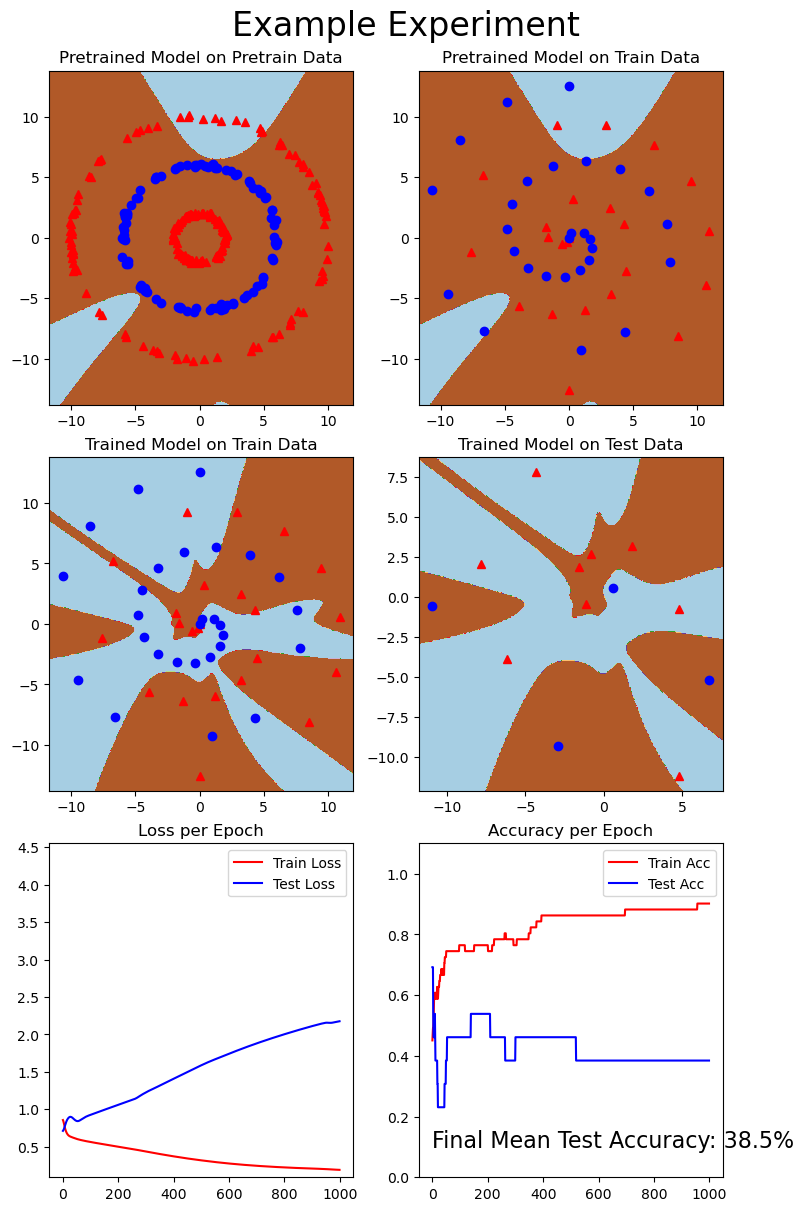

In [8]:
# Example experiment; you should copy this cell several times,
#   edit the kwargs, and save the figure outputs to your notebook.
kwargs = {
    "title": "Example Experiment",
    "radii": (2, 6, 10),
    "examples_per_ring": 100,
    "layer_sizes": [100, 10],
    "activation": torch.tanh,
    "learning_rate": 0.001,
    "n_pretrain_epochs": 100,
    "n_train_epochs": 1000,
}

run_experiment(**kwargs)

## Problem 1: Loss Function Analysis

### 1. Perceptron (Zero-One Loss)

- **Highest loss value**: 1 — occurs when the model misclassifies a point. Examples: (4, 3), (10, 3)
- **Lowest loss value**: 0 — occurs when prediction and label agree. Examples: (1, 2), (2, 1), (2, 3)
- **Can we lower the total loss with another boundary?** Yes. We can draw a line that only misclassifies one point instead of two. One option is to cut horizontally through y > 1.6 or vertically at x > 2.5.
- **Is this a good loss for MLPs?** No. There are no gradients — just 0 or 1 — so it completely breaks backpropagation. Not usable for training neural nets.

---

### 2. Squared Error Loss

- **Highest loss value**: (2, 1) — squaring (1 - 3.5) gives 6.25
- **Lowest loss value**: (2, 3) — squaring (–1 - (–1.1)) gives 0.01
- **Can we lower the loss?** Yes. Rotating or sliding the boundary could increase the margin for correctly classified points while reducing the prediction error for misclassified ones.
- **Is this good for classification?** Not really. It penalizes you for being far from 1 or –1 even if the sign is correct. That’s not ideal when you only care about the sign.

---

### 3. Binary Cross-Entropy Loss

- **Highest loss value**: (2, 1) — plug g(X) into BCE, and the value is around 1.7
- **Lowest loss value**: (10, 3) — BCE outputs around 0.0022 here
- **Can we lower the loss?** Yes. If we shift the line counter-clockwise and move it down, we could flip some of the confident mistakes and significantly reduce their loss.
- **Is this good for classification?** Yes. BCE provides smooth gradients and punishes confident wrong answers the most, which is exactly what you want when training with gradient descent.

---

### 4. Hinge Loss

- **Highest loss value**: (2, 1) — hinge = max(0, 1 – y·g(x)) → max(0, 1 – (–1)(1.5)) = 2.5
- **Lowest loss value**: (10, 3) and (2, 3) — both have margins well above 1, so hinge = 0
- **Can we lower the loss?** Yes. Hinge loss penalizes not only mistakes but also low-margin correct guesses. So, pushing correct points farther from the boundary would reduce loss.
- **Is this good for classification?** Yes. It prefers large margins and penalizes ambiguous points near the decision boundary. Great for clean, confident separation.



# Problem 2
# Design Choices
Honestly, we kept it pretty consistent with the specs. We used a single-layer perceptron as outlined by the problem.

This model is simple and interpretable, and it aligns with the goal of understanding gradient-based optimization without deep learning frameworks.

Loss functions:
We implemented four standard losses:

Mean Squared Error (MSE): Common in regression, but here used to penalize continuous output errors.

Binary Cross Entropy (BCE): Ideal for binary classification with probabilistic interpretation.

Hinge Loss: Used in SVMs; focuses on maximizing the margin between classes.

Perceptron Loss: The classic loss for a single-layer perceptron, punishes only misclassified points.

These were also given by the problem

Gradient computation:

Gradients were derived by hand for each loss function and implemented using NumPy. We explicitly separated the gradient for the bias term and the feature weights to ensure clarity.

Optimization method:
We used full-batch gradient descent with:

Learning rate: 0.01, chosen as a conservative default for stability.

Epochs: 500. We honestly arbitrarily chosed this because this seems like way larger than we would need for the data to converge. 

Data splitting:
We split the augmented dataset into:

60% training

20% validation

20% testing

All splits were stratified using a fixed random_state=2025 to ensure reproducibility. We chose the training split as it's mostly convention.



# Could we use another learning method?
Absolutely! As Professor Demeter like to say: "Neural nets are always the answer". Other potential upgrades: 

MLPs (multi-layer perceptrons) are the most obvious upgrade. They extend the basic perceptron by stacking additional layers and applying non-linear activations like ReLU or tanh. This gives them the ability to learn non-linear boundaries, which is critical if your data isn't linearly separable. The downside is that they’re more complex to train, need more compute, and require tuning hyperparameters like layer size, learning rate, and regularization to not overfit. 

K-Nearest Neighbors is the exact opposite of an MLP — zero training, 100% brute force at inference. It memorizes the training data and classifies by whatever the majority of your k nearest neighbors are doing. It’s conceptually simple and actually pretty effective in low-dimensional problems like this. But once your data gets bigger or messier, it becomes painfully slow and starts to fall apart in high dimensions due to the curse of dimensionality.

Decision Trees are a nice middle ground. They're non-parametric and can learn complex decision boundaries without needing to scale data or assume linearity. If you're willing to give up interpretability, Random Forests (i.e., ensembles of decision trees) usually outperform most basic models. The tradeoff is they can be hard to debug, and while they tend to generalize well, they’re not as mathematically elegant as methods with convex loss functions.



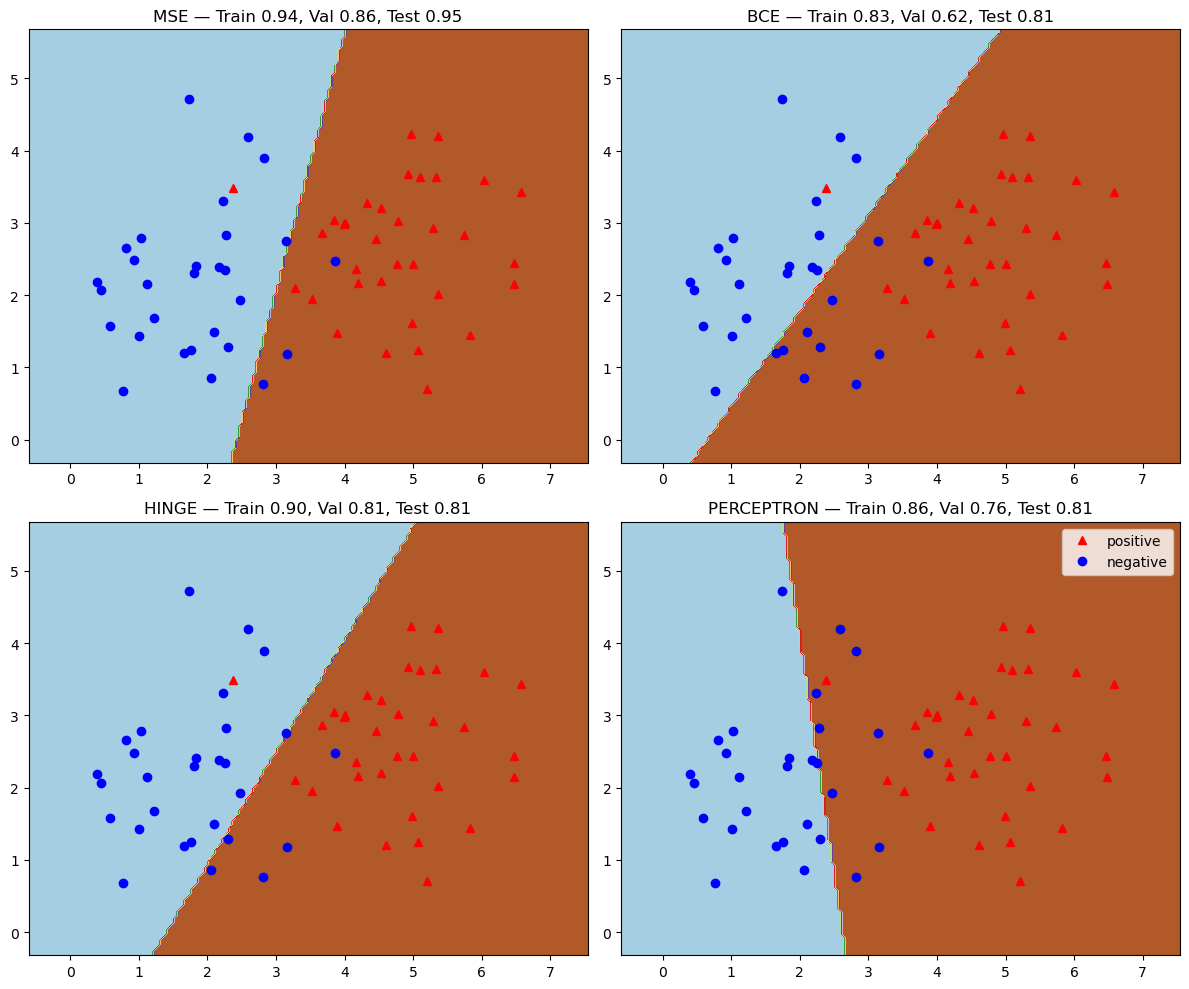

Accuracy Summary:


,Train Accuracy,Validation Accuracy,Test Accuracy
mse,0.936508,0.857143,0.952381
bce,0.825397,0.619048,0.809524
hinge,0.904762,0.809524,0.809524
perceptron,0.857143,0.761905,0.809524


In [9]:
# Question 2: 

def sigmoid(x):
    """
    Sigmoid activation function we are going to use for binary cross entropy 
    """
    return 1 / (1 + np.exp(-x))

def train_single_layer_perceptron(
    loss_type, gradient_function, features, labels,
    learning_rate=0.01, num_epochs=500
):
    """
    Train a single-layer perceptron using full-batch gradient descent.
    """
    weights = np.zeros(3)  # [bias, w1, w2]
    loss_history = []

    for epoch in range(num_epochs):
        bias = weights[0]
        linear_output = bias + features.dot(weights[1:])

        # Compute and store loss
        if loss_type == 'mse':
            loss = np.mean((linear_output - labels) ** 2)
        elif loss_type == 'bce':
            target_prob = (labels + 1) / 2  # convert from [-1, 1] to [0, 1]
            prediction = sigmoid(linear_output)
            loss = -np.mean(target_prob * np.log(prediction) + (1 - target_prob) * np.log(1 - prediction))
        elif loss_type == 'hinge':
            loss = np.mean(np.maximum(0, 1 - labels * linear_output))
        elif loss_type == 'perceptron':
            loss = np.mean(np.maximum(0, -labels * linear_output))
        else:
            raise ValueError(f"Unsupported loss type: {loss_type}")

        loss_history.append(loss)

        # Perform gradient descent update
        gradient = gradient_function(weights, features, labels)
        weights -= learning_rate * gradient

    return weights, loss_history

def mse_gradient(weights, features, labels):
    """
    MSE gradient 
    """
    bias = weights[0]
    linear_output = bias + features.dot(weights[1:])
    gradient = np.zeros_like(weights)

    # Compute gradients
    gradient[0] = np.mean(2 * (linear_output - labels))
    gradient[1:] = 2 * features.T.dot(linear_output - labels) / len(labels)

    return gradient

def bce_gradient(weights, features, labels):
    """
    BCE Gradient 
    """
    bias = weights[0]
    logits = bias + features.dot(weights[1:])
    targets = (labels + 1) / 2  # Convert to {0, 1}
    predictions = sigmoid(logits)

    bias_grad = np.mean(predictions - targets)
    weights_grad = ((predictions - targets)[:, None] * features).mean(axis=0)

    gradient = np.hstack([bias_grad, weights_grad])
    return gradient

def hinge_gradient(weights, features, labels):
    """
    Hinge Loss Gradient 
    """
    bias = weights[0]
    margin = bias + features.dot(weights[1:])
    violated = (1 - labels * margin) > 0

    if violated.any():
        bias_grad = np.mean(-labels[violated])
        weights_grad = (-labels[violated][:, None] * features[violated]).mean(axis=0)
    else:
        bias_grad = 0
        weights_grad = np.zeros(features.shape[1])

    gradient = np.hstack([bias_grad, weights_grad])
    return gradient
# Create a simple linear model using learned weights
def make_linear_classifier(weight_vector):
    return lambda input_data: np.sign(weight_vector[0] + input_data.dot(weight_vector[1:]))


def perceptron_gradient(weights, features, labels):
    """
    Perceptron Loss Gradient 
    """
    bias = weights[0]
    predictions = bias + features.dot(weights[1:])
    misclassified = (labels * predictions) <= 0

    if misclassified.any():
        bias_grad = np.mean(-labels[misclassified])
        weights_grad = (-labels[misclassified][:, None] * features[misclassified]).mean(axis=0)
    else:
        bias_grad = 0
        weights_grad = np.zeros(features.shape[1])

    gradient = np.hstack([bias_grad, weights_grad])
    return gradient
# Load the augmented dataset
df = pd.read_csv("augmented_dataset.csv")

# Split into features (X) and labels (y)
X = df[["x1", "x2"]].values  # shape (n_samples, 2)
y = df["y"].values           # shape (n_samples,)

# (60 Train/20 Evaluation/20 test splits)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=2025)
X_val, X_test, y_val, y_test   = train_test_split(X_temp, y_temp, test_size=0.5, random_state=2025)
answers = {
}
for loss_type, gradient_function in [
    ('mse', mse_gradient),
    ('bce', bce_gradient),
    ('hinge', hinge_gradient),
    ('perceptron', perceptron_gradient)
]:
    # Train the model
    weights, loss_history = train_single_layer_perceptron(
        loss_type, gradient_function, X_train, y_train,
        learning_rate=0.01, num_epochs=500
    )

        # Create model from learned weights
    classifier = make_linear_classifier(weights)

    # Compute predictions
    y_pred_train = classifier(X_train)
    y_pred_val   = classifier(X_val)
    y_pred_test  = classifier(X_test)

    # Compute accuracy
    train_acc = accuracy_score(y_train, y_pred_train)
    val_acc   = accuracy_score(y_val, y_pred_val)
    test_acc  = accuracy_score(y_test, y_pred_test)

    # Store all results
    answers[loss_type] = {
        'weights': weights,
        'loss_history': loss_history,
        'train_acc': train_acc,
        'val_acc': val_acc,
        'test_acc': test_acc
    }



# Set up subplots for each loss function
fig, axes_grid = plt.subplots(2, 2, figsize=(12, 10))
axes_flat = axes_grid.ravel()

# Plot each loss function's decision boundary
for axis, (loss_name, loss_result) in zip(axes_flat, answers.items()):
    classifier = make_linear_classifier(loss_result['weights'])
    plot_data(X_train, y_train, ax=axis)
    decision_bounds = compute_bounds(X_train)
    plot_decision_surface(model=classifier, axis_limits=decision_bounds, ax=axis)
    axis.set_title(
        f"{loss_name.upper()} — Train {loss_result['train_acc']:.2f}, "
        f"Val {loss_result['val_acc']:.2f}, "
        f"Test {loss_result['test_acc']:.2f}"
    )

plt.tight_layout()
plt.show()

# Display performance summary as a DataFrame
accuracy_table = pd.DataFrame({
    loss_name: {
        'Train Accuracy': loss_result['train_acc'],
        'Validation Accuracy': loss_result['val_acc'],
        'Test Accuracy': loss_result['test_acc']
    }
    for loss_name, loss_result in answers.items()
}).T

print("Accuracy Summary:")
display(accuracy_table)
